In [67]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import MaxNLocator
import plotly.express as px
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, k_means
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import joblib
import pickle
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
from matplotlib.ticker import FuncFormatter

In [68]:
TIME_FORMAT = '%Y-%m-%d'
DROPNA = True
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']

root_path = Path('./data/')

targets = pd.read_csv(root_path / 'targets.csv')

mortality = pd.read_csv('../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
img_path = Path('./img')
result_data_path = Path('./result_data')
result_models_path = Path('./models')

img_path.mkdir(exist_ok=True)
result_data_path.mkdir(exist_ok=True)

## Preprocessing

**Prerequisites**: factors_ranking.ipynb notebook has been run so factors_main.csv exists, as well list of final features

In [111]:
tmp_targets[['transfer_year','temperature_cleared-before_first_feeding-degree_days','temperature_cleared-before_first_feeding-mean']].groupby('transfer_year').median()

,temperature_cleared-before_first_feeding-degree_days,temperature_cleared-before_first_feeding-mean
transfer_year,,
2017,NaN,NaN
2018,379.519098,5.088600
2019,390.172128,7.004092
2020,390.500606,6.732769
2021,410.445111,5.754950
2022,922.084866,7.144876
2023,727.401694,4.603570


In [115]:
tmp_targets[['fw_cycle_length_first_mvmt_shipout','mortality','nSFR','temperature_cleared-before_first_feeding-degree_days']].corr()

,fw_cycle_length_first_mvmt_shipout,mortality,nSFR,temperature_cleared-before_first_feeding-degree_days
fw_cycle_length_first_mvmt_shipout,1.000000,-0.031308,-0.126713,0.015903
mortality,-0.031308,1.000000,-0.107788,-0.104036
nSFR,-0.126713,-0.107788,1.000000,-0.012448
temperature_cleared-before_first_feeding-degree_days,0.015903,-0.104036,-0.012448,1.000000


In [91]:
# path_factors_df = result_data_path / 'main' / 'factors_main.csv'
path_factors_df = result_data_path / 'main' / 'factors_main_for_clustering.csv'
# path_features_list = result_data_path / 'factor_ranking' / 'final_features.csv'
path_features_list = result_data_path / 'factor_ranking' / 'smolt_quality_final_features_importance.csv'

factors = pd.read_csv(path_factors_df,encoding="windows-1252")
# features = pd.read_csv(path_features_list,encoding="windows-1252").factor
features = pd.read_csv(path_features_list).factor

test_factors = factors[factors['transfer_year'] == 2023]
factors = factors[factors['transfer_year'] != 2023]

# May vary depending on features themselves

to_drop_features = [
    'ph-8_weeks_before_transfer-max',
    'av.light_hours_per_day_vac',
]

to_add_features = [
#     'fw_cycle_length_vac_shipout'
]

features = features[~features.isin(to_drop_features)]
features = features.values.tolist()
features = features + to_add_features

factors = factors[key_columns + features]
# # factors

In [92]:
# features=features[:12]

In [93]:
factors_targets = factors.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets[key_columns + ['nSFR']]
)

factors_targets_key = factors_targets.copy()
factors_targets.drop(key_columns, inplace=True, axis=1)

factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)

factors_targets['mortality_perc'] = factors_targets['mortality'] * 100

target = 'mortality_perc'

In [94]:
display(factors_targets[features].isna().sum())

temperature_fw_sw_diff                                  276
atpasa_derivative                                       780
number_of_weeks_with_summer_vac_transfer                823
temperature_cleared-before_first_feeding-mean           338
is_luf_weighted                                           0
fw_cycle_length_first_mvmt_shipout                        0
temperature_cleared-before_first_feeding-degree_days    338
is_nacl-whole_period-sum                                137
is_nacl-after_first_feeding-sum                         137
mortality_rate-after_first_feeding-sum_Desadaptado      137
temperature_cleared-transfer_feeding-median             276
atpasa_last                                             780
mortality_rate-whole_period-sum_Embrionaria             137
is_bronopol-whole_period-sum                            137
sfr-4_weeks_before_transfer-relative_lower_min-0.01     275
ammonium-2_weeks_before_transfer-mean                   673
vac_conf_days                           

In [95]:
nan_threshold = 0.33
features_high_cov = [x for x in factors_targets[features].columns if (factors_targets[features][x].isna().sum() / len(factors_targets[features])) < nan_threshold]
print(len(factors_targets[features]))
features_high_cov

1090


['temperature_fw_sw_diff',
 'temperature_cleared-before_first_feeding-mean',
 'is_luf_weighted',
 'fw_cycle_length_first_mvmt_shipout',
 'temperature_cleared-before_first_feeding-degree_days',
 'is_nacl-whole_period-sum',
 'is_nacl-after_first_feeding-sum',
 'mortality_rate-after_first_feeding-sum_Desadaptado',
 'temperature_cleared-transfer_feeding-median',
 'mortality_rate-whole_period-sum_Embrionaria',
 'is_bronopol-whole_period-sum',
 'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
 'vac_conf_days',
 'sfr-2_weeks_before_transfer-relative_lower_min-0.01',
 'temperature_cleared-transfer_feeding-degree_days',
 'mortality_rate-6_weeks_before_transfer-sum',
 'mortality_rate-whole_period-sum_Eliminación Deforme',
 'vac_weight',
 'is_desinfected_mean',
 'weight_M',
 'days_btw_to_from',
 'vac_fish_count_mean',
 'is_cloramina t-whole_period-sum',
 'drop_count_coef=0.5']

In [96]:
if DROPNA:
    factors_targets = factors_targets[features_high_cov+['mortality',
       'tgc', 'nSFR', 'mortality_perc']].dropna()
    features_full = features.copy()
    features = features_high_cov
    print(len(factors_targets[features]))
else:
    factors_targets[features] = factors_targets[features].fillna(factors_targets[features].median())

592


In [77]:
factors_targets_=factors_targets_key.copy()
factors_targets_.drop(['locus_id','fish_group_id'], inplace=True, axis=1)

In [78]:
scaler = RobustScaler()

factors_targets_scaled = factors_targets.copy()
factors_targets_scaled[features] = scaler.fit_transform(factors_targets_scaled[features])

In [79]:
save_path = result_data_path / 'clustering'
save_path.mkdir(exist_ok=True)
pd.DataFrame({'factor':features_high_cov})#.to_csv(f'{save_path}/features_used_for_clustering.csv', index=False)

,factor
0,temperature_fw_sw_diff
1,temperature_cleared-before_first_feeding-mean
2,is_luf_weighted
3,fw_cycle_length_first_mvmt_shipout
4,temperature_cleared-before_first_feeding-degre...
5,is_nacl-whole_period-sum
6,is_nacl-after_first_feeding-sum
7,mortality_rate-after_first_feeding-sum_Desadap...
8,temperature_cleared-transfer_feeding-median
9,mortality_rate-whole_period-sum_Embrionaria


## Clustering

### 1. DBSCAN parameter search

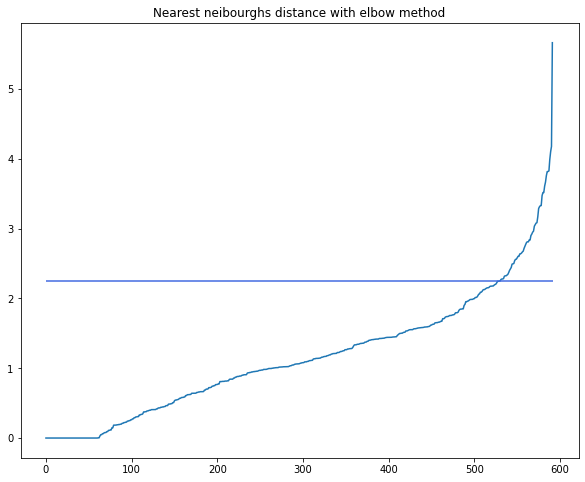

In [56]:
n_neighbors = 0.01 * factors_targets_scaled.shape[0]
n_neighbors = round(n_neighbors / 10) * 10  # round to the nearest 10

nn = NearestNeighbors(n_neighbors=n_neighbors).fit(factors_targets_scaled[features])
distances, _ = nn.kneighbors(factors_targets_scaled[features])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10, 8))
plt.title('Nearest neibourghs distance with elbow method')
plt.plot(distances)

ELBOW_EPS = 2.25
# ELBOW_EPS = 1.1


plt.hlines(y=ELBOW_EPS, xmin=0, xmax=len(distances), color='royalblue')
plt.show()

In [57]:
samples_range = np.arange(5, 55, 5)
eps_range = np.arange(-0.3 + ELBOW_EPS, 0.3 + ELBOW_EPS, 0.025)

dbscan_grid_search = {
    'min_samples': [],
    'eps': [],
    'silhouette_score': [],
    'cluster_count': []
}

for min_samples in samples_range:
    for eps in eps_range:
        labels = DBSCAN(min_samples=min_samples, eps=eps).fit(factors_targets_scaled[features]).labels_
        try:
            score = silhouette_score(factors_targets_scaled[features], labels)
        except ValueError:
            score = -1
        dbscan_grid_search['min_samples'].append(min_samples)
        dbscan_grid_search['eps'].append(eps)
        dbscan_grid_search['silhouette_score'].append(score)
        dbscan_grid_search['cluster_count'].append(np.unique(labels).shape[0])
dbscan_grid_search = pd.DataFrame(dbscan_grid_search)


CLUSTER_THRESHOLD = 100  # max clusters allowed
dbscan_grid_search = dbscan_grid_search[dbscan_grid_search['cluster_count'] < CLUSTER_THRESHOLD]
best_params = dbscan_grid_search[
    dbscan_grid_search['silhouette_score'] == dbscan_grid_search['silhouette_score'].max()
]

In [58]:
# Save the DBSCAN model to a file
best_min_samples = best_params['min_samples'].values[0]
best_eps = best_params['eps'].values[0]
best_dbscan_model = DBSCAN(min_samples=best_min_samples, eps=best_eps)
best_dbscan_model.fit(factors_targets_scaled[features])

save_path = result_data_path / 'clustering' / 'models'
save_path.mkdir(exist_ok=True)
model_filename = "dbscan_model(clustering).pkl"
joblib.dump(best_dbscan_model, f'{save_path}/{model_filename}')

DBSCAN(eps=2.4499999999999984)

In [59]:
min_samples, eps = best_params['min_samples'].iloc[0], best_params['eps'].iloc[0]
score = best_params['silhouette_score'].iloc[0]

dbscan = DBSCAN(min_samples=min_samples, eps=eps)
factors_targets_scaled['cluster'] = dbscan.fit(factors_targets_scaled[features]).labels_

In [60]:
print('Best clusterization sillhoute score:', score)

Best clusterization sillhoute score: 0.17845182729707346


In [530]:
best_params

,min_samples,eps,silhouette_score,cluster_count
20,5,2.45,0.178452,27


### 2. Clustering Visualization

c:\users\fckmc\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\fckmc\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


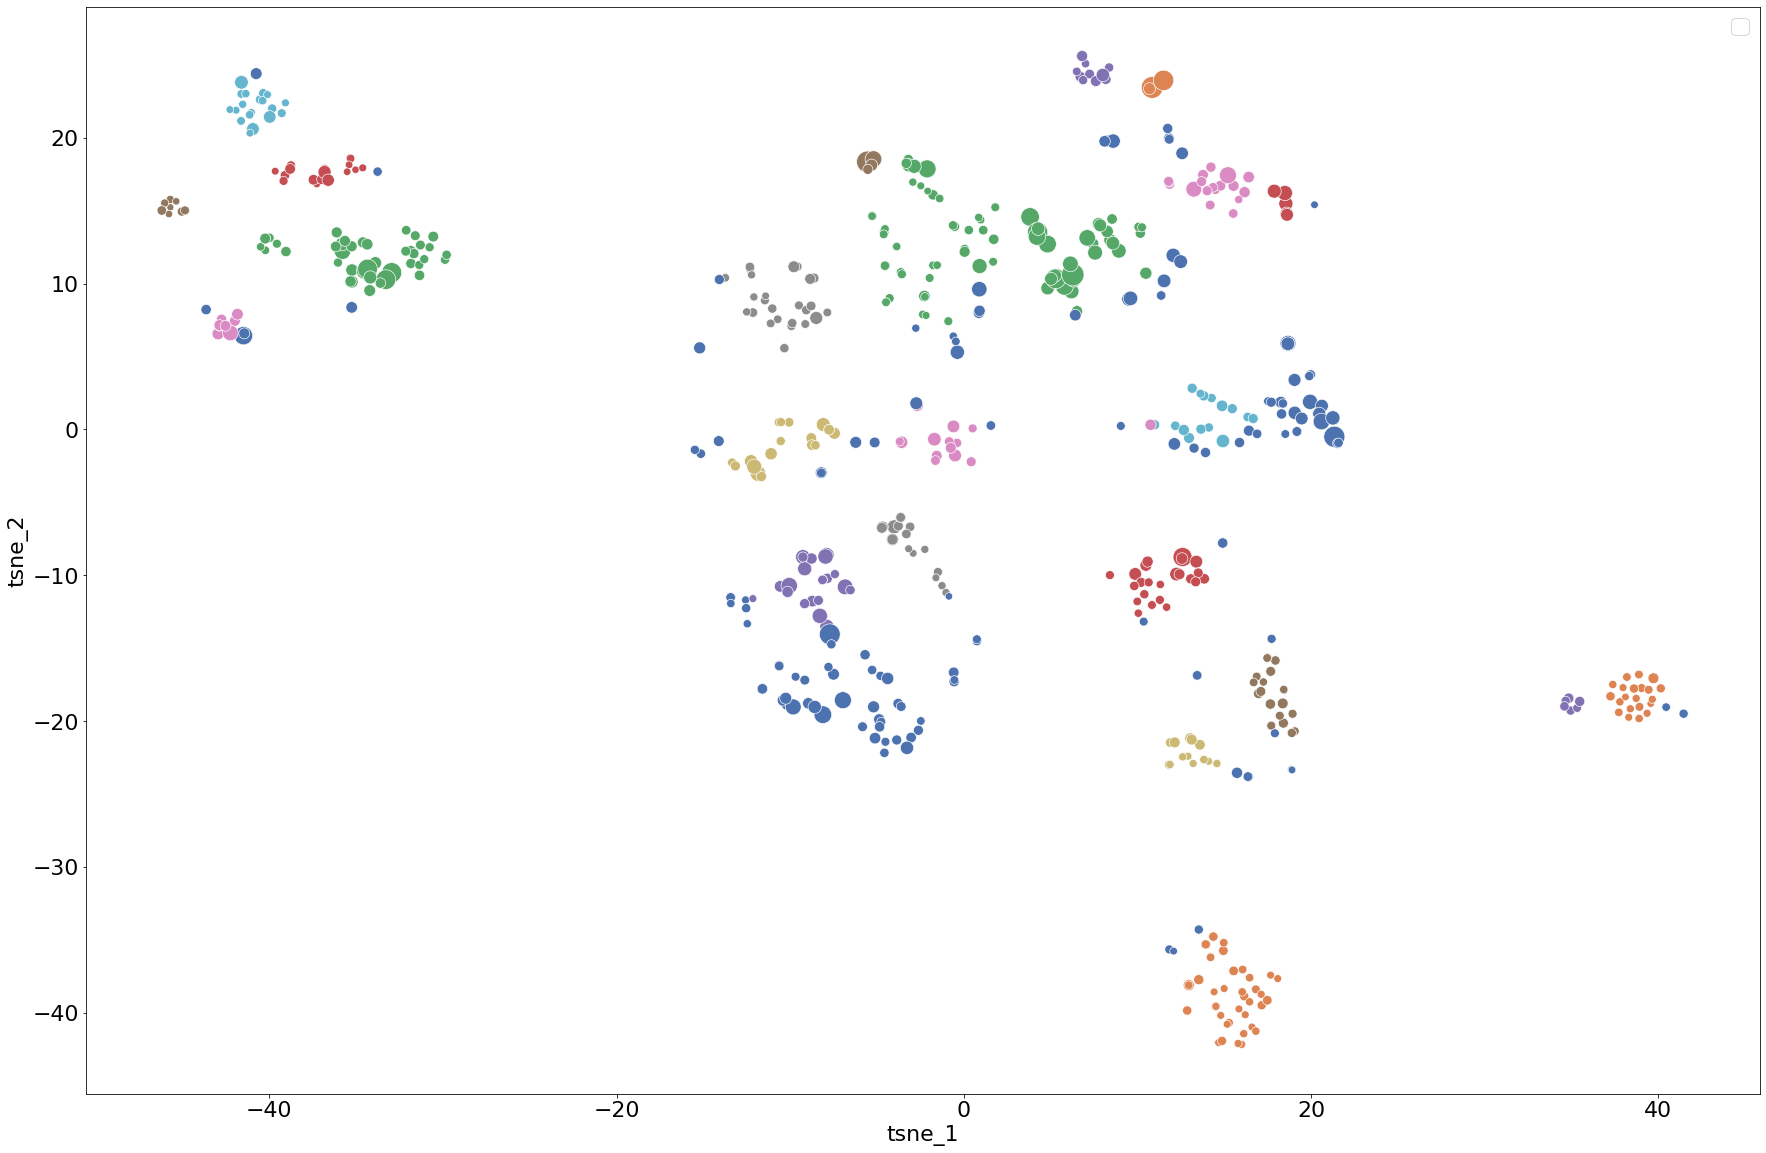

In [66]:
tsne = TSNE(n_components=2)
factors_tsne = tsne.fit_transform(factors_targets_scaled[features])

factors_targets_scaled['tsne_1'] = factors_tsne[:, 0]
factors_targets_scaled['tsne_2'] = factors_tsne[:, 1]

font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=factors_targets_scaled,
    x="tsne_1",
    y="tsne_2",
    hue="cluster",
    size=target,
    sizes=(50, 500),
    palette='deep'
)

plt.legend([])
save_path = img_path / 'clustering'
save_path.mkdir(exist_ok=True)
plt.savefig(f'{save_path}/dbscan_clustering_with_noise_cluster.jpg',dpi=300)

c:\users\fckmc\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\fckmc\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


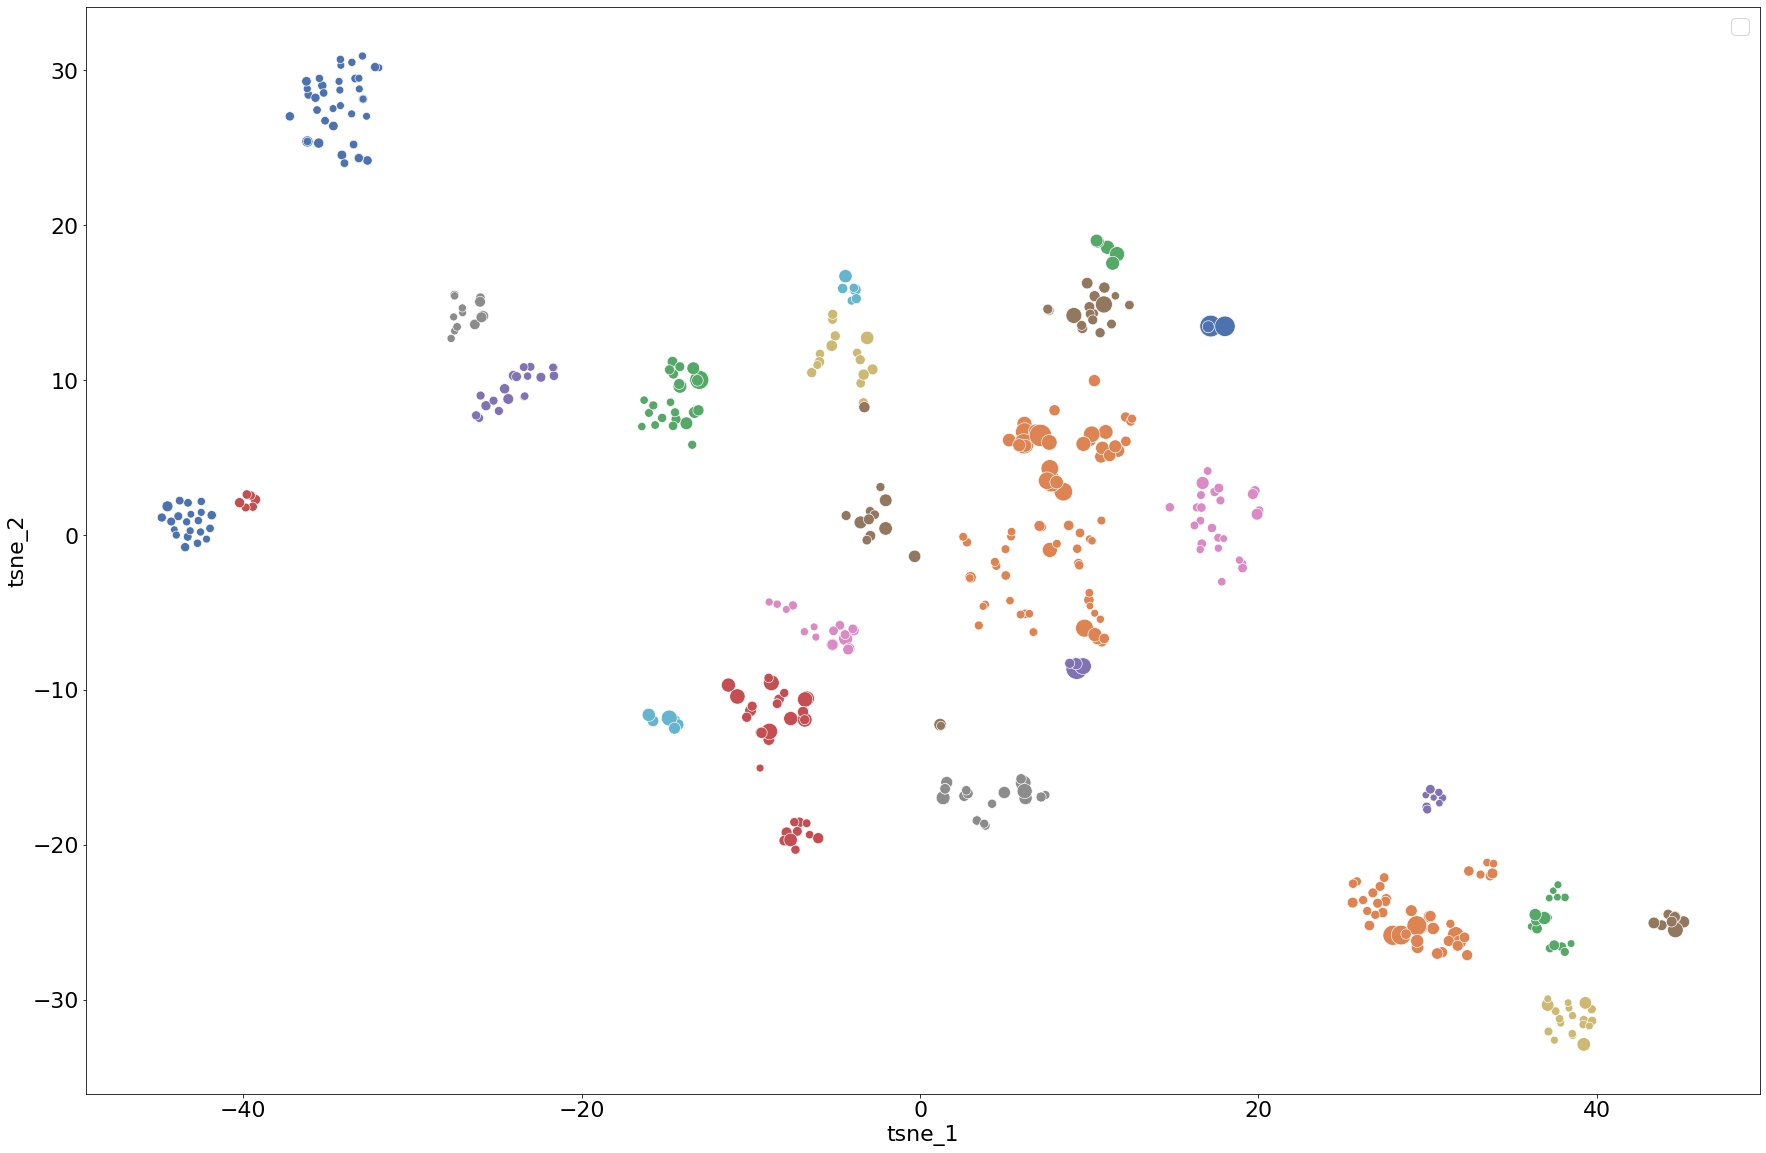

In [65]:
tsne = TSNE(n_components=2)
factors_tsne = tsne.fit_transform(factors_targets_scaled[features])

factors_targets_scaled['tsne_1'] = factors_tsne[:, 0]
factors_targets_scaled['tsne_2'] = factors_tsne[:, 1]

font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=factors_targets_scaled[factors_targets_scaled['cluster'] != -1],
    x="tsne_1",
    y="tsne_2",
    hue="cluster",
    size=target,
    sizes=(50, 500),
    palette='deep'
)

plt.legend([])
save_path = img_path / 'clustering'
save_path.mkdir(exist_ok=True)
plt.savefig(f'{save_path}/dbscan_clustering_without_noise_cluster.jpg',dpi=300)

In [553]:
cluster_size_threshold = 8
cluster_sizes = factors_targets_scaled[factors_targets_scaled['cluster'] != -1]['cluster'].value_counts()
big_enough_clusters=[x for x in cluster_sizes.index if (cluster_sizes.loc[x]>=cluster_size_threshold)]

cluster_groupby = factors_targets_scaled[factors_targets_scaled['cluster'].isin(big_enough_clusters)].groupby('cluster')


TOP_N = 5

top_5_clusters_by_mortality = cluster_groupby['mortality_perc'].mean().sort_values().iloc[0:TOP_N].index
top_5_clusters_by_nsfr = cluster_groupby['nSFR'].mean().sort_values(ascending=False).iloc[0:TOP_N].index

best_clusters = top_5_clusters_by_mortality.intersection(top_5_clusters_by_nsfr)
assert best_clusters.tolist(), 'increase number of top clusters'

save_path = result_data_path / 'clustering'
save_path.mkdir(exist_ok=True)
pd.Series(top_5_clusters_by_mortality).to_csv(f'{save_path}/top_5_clusters_by_mortality.csv', index=False)
pd.Series(top_5_clusters_by_nsfr).to_csv(f'{save_path}/top_5_clusters_by_nsfr.csv', index=False)
pd.Series(best_clusters).to_csv(f'{save_path}/best_clusters.csv', index=False)

In [102]:
factors_targets_scaled[factors_targets_scaled['cluster'].isin(big_enough_clusters)]

KeyError: 'cluster'

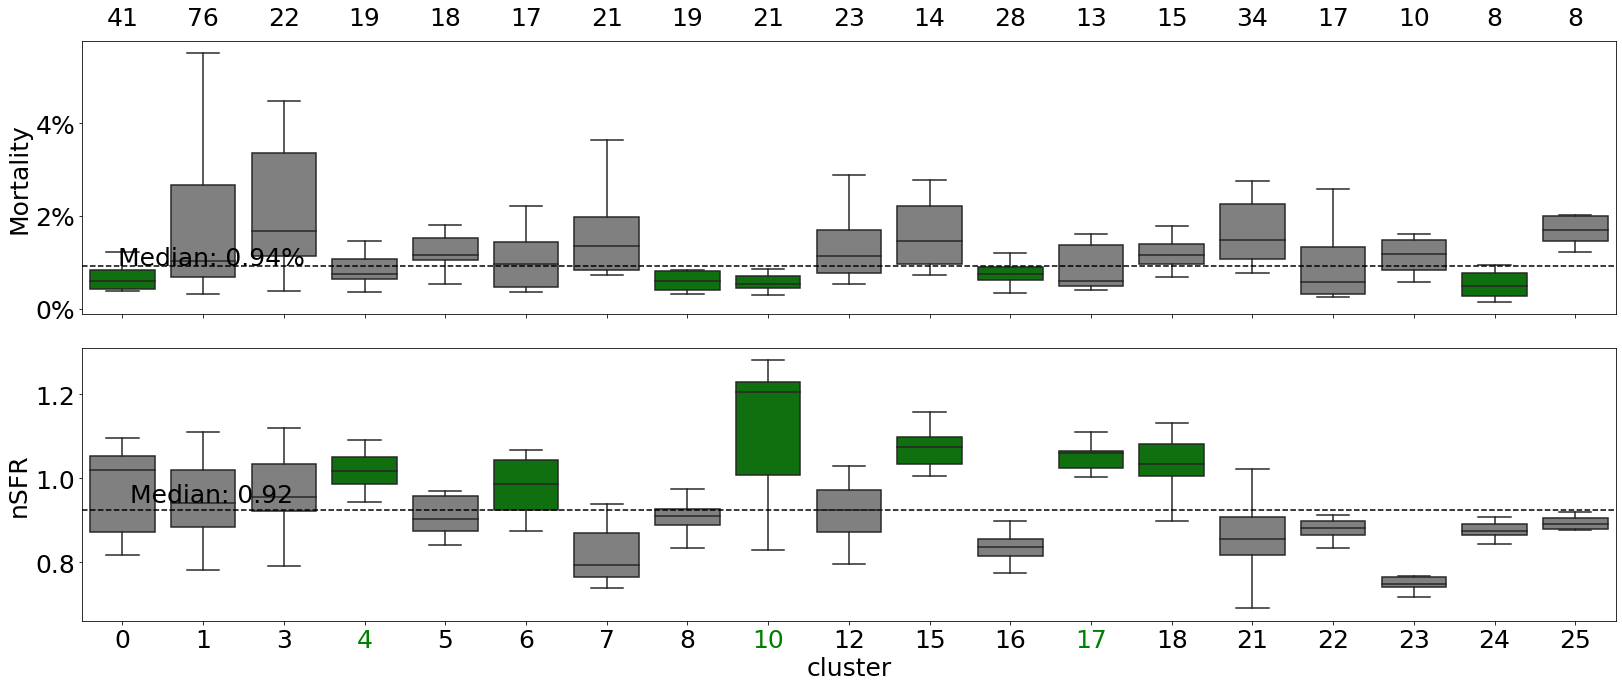

In [554]:
first_plot_target = 'mortality'
arr_for_chart = factors_targets_scaled[factors_targets_scaled['cluster'].isin(big_enough_clusters)]

fontsize = 25
max_cluster = arr_for_chart['cluster'].max()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(23, 10))
cluster_counts = arr_for_chart.groupby('cluster').size()
target_median = arr_for_chart[first_plot_target].median()
target_pallete = []
for quantile in arr_for_chart.groupby('cluster')[first_plot_target].quantile(0.75):
    if quantile < target_median:
        target_pallete.append('green')
    else:
        target_pallete.append('grey')

sns.boxplot(
    data=arr_for_chart,
    x='cluster',
    y=first_plot_target,
    showfliers=False,
    ax=axes[0],
    palette=target_pallete
)

axes[0].set_ylabel(first_plot_target.capitalize(), fontsize=fontsize)
axes[0].set_xlabel('')
axes[0].set_xticklabels([])
axes[0].tick_params(axis='both', labelsize=fontsize)
# axes[0].set_ylim([0,0.04])
# Apply percentage formatter to y-axis in the first subplot
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, y: f'{x * 100:.0f}%'))

# Add median vertical line and annotation for the first subplot
axes[0].axhline(y=target_median, color='black', linestyle='--', label='Median')
axes[0].annotate(
    f'Median: {target_median*100:.2f}%',
    xy=(0.5, target_median),
    xytext=(1.1, target_median*1.02),
    color='black',
    fontsize=fontsize,
    ha='center'
)

# Add cluster counts at the top of the first chart
for cluster, count in enumerate(cluster_counts):
    axes[0].text(cluster, .06, f'{count}', color='black', ha='center', va='bottom', fontsize=fontsize)

# Plot the second boxplot in the second subplot with conditional color
second_plot_target = 'nSFR'

target_median = arr_for_chart[second_plot_target].median()
target_pallete = []
for quantile in arr_for_chart.groupby('cluster')[second_plot_target].quantile(0.25):
    if quantile > target_median:
        target_pallete.append('green')
    else:
        target_pallete.append('grey')

sns.boxplot(
    data=arr_for_chart,
    x='cluster',
    y=second_plot_target,
    showfliers=False,
    ax=axes[1],
    palette=target_pallete
)
axes[1].set_xlabel('cluster', fontsize=fontsize)
axes[1].set_ylabel(second_plot_target, fontsize=fontsize)
axes[1].tick_params(axis='both', labelsize=fontsize)

# Add median vertical line and annotation for the second subplot
axes[1].axhline(y=target_median, color='black', linestyle='--', label='Median')
axes[1].annotate(
    f'Median: {target_median:.2f}',
    xy=(0.5, target_median), xytext=(1.1, target_median*1.02),
    color='black',
    fontsize=fontsize,
    ha='center'
)

mask = pd.Series(cluster_counts.index.isin(best_clusters), index = cluster_counts.index)

# Set the x-label colors
for label in axes[1].get_xticklabels():
    if mask[int(label.get_text())]:
        label.set_color('green')
#     label.set_fontsize(14)

plt.tight_layout()

save_path = img_path / 'clustering'
save_path.mkdir(exist_ok=True)
plt.savefig(f'{save_path}/cluster_targets_chart.jpg', dpi=300)

### 3. Cluster parameter description 

In [555]:
if DROPNA:
    factors_targets = factors_targets.dropna()
    assert factors_targets.shape[0] == factors_targets_scaled.shape[0]
else:
    factors_targets[features] = factors_targets[features].fillna(factors_targets[features].median())
factors_targets['cluster'] = factors_targets_scaled['cluster']


def calculate_parameters(factor_df, features):
    mean = factor_df.groupby('cluster')[features].mean().reset_index()
    for col in features:
        mean.rename(columns={col: f'{col}_mean'}, inplace=True)
#         mean.rename(columns={col: f'{col}_mean'}, inplace=True)
    
    median = factor_df.groupby('cluster')[features].median().reset_index()
    for col in features:
        median.rename(columns={col: f'{col}_median'}, inplace=True)
#         mean.rename(columns={col: f'{col}_median'}, inplace=True)
        
    quantile_25 = factor_df.groupby('cluster')[features].quantile(0.25).reset_index()
    for col in features:
        quantile_25.rename(columns={col: f'{col}_quantile_0.25'}, inplace=True)
#         quantile_25.rename(columns={col: f'{col}_quantile_0.25'}, inplace=True)

    quantile_75 = factor_df.groupby('cluster')[features].quantile(0.75).reset_index()
    for col in features:
        quantile_75.rename(columns={col: f'{col}_quantile_0.75'}, inplace=True)
#         quantile_75.rename(columns={col: f'{col}_quantile_0.75'}, inplace=True)

    std_ = factor_df.groupby('cluster')[features].std().reset_index()
    for col in features:
        std_.rename(columns={col: f'{col}_std'}, inplace=True)
#         std_.rename(columns={col: f'{col}_std'}, inplace=True)

    cv_ = factor_df.groupby('cluster')[features].apply(lambda x: np.std(x) / np.mean(x)).reset_index()
    for col in features:
        cv_.rename(columns={col: f'{col}_cv'}, inplace=True)
#         cv_.rename(columns={col: f'{col}_cv'}, inplace=True)
        
    params = mean\
    .merge(quantile_25, on='cluster', how='inner')\
    .merge(quantile_75, on='cluster', how='inner')\
    .merge(std_, on='cluster', how='inner')\
    .merge(cv_, on='cluster', how='inner')\
    .merge(median, on='cluster', how='inner')

    
    return params

In [556]:
factors_targets__ = factors_targets_.merge(factors_targets['cluster'],left_index=True,right_index=True)

scaler3 = RobustScaler()
transfer_year_rscaled= scaler3.fit_transform(factors_targets__[['transfer_year']])

scaler4 = MinMaxScaler()
transfer_year_mmscaled=scaler4.fit_transform(factors_targets__[['transfer_year']])

In [557]:
params_unscaled = calculate_parameters(factors_targets__, features_full+['transfer_year','total_mortality_perc_90','nSFR'])
params_scaled = calculate_parameters(factors_targets_scaled, features)

save_path = result_data_path / 'clustering'
save_path.mkdir(exist_ok=True)
params_unscaled.to_csv(f'{save_path}/unscaled_factors_parameters_by_cluster.csv', index=False)
params_scaled.to_csv(f'{save_path}/scaled_factors_parameters_by_cluster.csv', index=False)

C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [563]:
tmp_count=pd.DataFrame(cluster_counts.loc[best_clusters]).reset_index()
tmp_count.columns = ['cluster','count']
tmp_count=pd.concat([tmp_count, pd.DataFrame({'cluster': ['all'], 'count': cluster_sizes.sum()})], ignore_index=True)
# tmp_add = pd.DataFrame(factors_targets__.groupby('cluster')[['transfer_year','total_mortality_perc_90','nSFR']].mean()).reset_index()
# tmp_add=pd.concat([tmp_add, pd.DataFrame({'cluster': ['all'], 'transfer_year': cluster_sizes.sum()})], ignore_index=True)
column_names = [x+'_median' for x in features_full+['transfer_year','total_mortality_perc_90','nSFR']]
values=factors_targets__[features_full+['transfer_year','total_mortality_perc_90','nSFR']].median().values
# column_names = [x+'_median' for x in features]
# values=factors_targets__[features].median().values
data = {'cluster': ['all'], **dict(zip(column_names, values))}
all_cluster_values = pd.DataFrame(data)
save_path = result_data_path / 'clustering'
save_path.mkdir(exist_ok=True)
best_clusters_medians = pd.concat([params_unscaled[['cluster']+[col for col in params_unscaled.columns if col.endswith("_median")]][params_unscaled.cluster.isin(best_clusters)],all_cluster_values])
best_clusters_medians=best_clusters_medians.merge(tmp_count,how='left').T
best_clusters_medians.to_csv(f'{save_path}/best_clusters_medians.csv')
best_clusters_full = pd.concat([params_unscaled[params_unscaled.cluster.isin(best_clusters)],all_cluster_values])
best_clusters_full=best_clusters_full.merge(tmp_count,how='left').T
best_clusters_full.to_csv(f'{save_path}/best_clusters_full.csv')
best_clusters_medians

,0,1,2,3
cluster,4,10,17,all
atpasa_derivative_median,NaN,NaN,NaN,0.279023
vac_conf_days_median,3.772451,2.664855,3.895668,2.778717
mortality_rate-whole_period-sum_Embrionaria_median,0.009458,0.031788,0.012181,0.01356
sfr-2_weeks_before_transfer-relative_lower_min-0.01_median,0.923077,1.0,0.987152,1.0
is_nacl-after_first_feeding-sum_median,0.389727,0.636108,0.627443,0.541216
is_luf_weighted_median,0.034436,0.0,0.0,0.035803
number_of_weeks_with_summer_vac_transfer_median,NaN,NaN,NaN,4.895406
weight_M_median,0.625309,0.0,0.0,0.0
fw_cycle_length_first_mvmt_shipout_median,432.0,517.0,466.33,458.275


In [562]:
params_unscaled[['cluster']+[col for col in params_unscaled.columns]]

,cluster,cluster,atpasa_derivative_mean,vac_conf_days_mean,mortality_rate-whole_period-sum_Embrionaria_mean,sfr-2_weeks_before_transfer-relative_lower_min-0.01_mean,is_nacl-after_first_feeding-sum_mean,is_luf_weighted_mean,number_of_weeks_with_summer_vac_transfer_mean,weight_M_mean,...,days_btw_to_from_median,is_bronopol-whole_period-sum_median,drop_count_coef=0.5_median,temperature_cleared-transfer_feeding-degree_days_median,is_cloramina t-whole_period-sum_median,temperature_cleared-transfer_feeding-median_median,sfr-4_weeks_before_transfer-relative_lower_min-0.01_median,transfer_year_median,total_mortality_perc_90_median,nSFR_median
0,-1,-1,0.215011,4.608757,0.023172,0.832053,0.500719,0.026963,4.821386,0.434992,...,1.0,0.006994,11.000000,3866.866577,0.012900,13.854646,0.703704,2020.0,0.011737,0.968888
1,0,0,NaN,4.970928,0.012958,0.907952,0.619183,0.044502,NaN,0.498322,...,2.0,0.078088,6.000000,3465.277325,0.012228,14.011320,0.629630,2019.0,0.005931,1.019742
2,1,1,0.330405,5.349990,0.013150,0.967583,0.587595,0.023011,7.604587,0.376523,...,1.0,0.006696,10.000000,3847.983740,0.007780,14.334341,0.814815,2019.0,0.010433,0.941958
3,2,2,NaN,1.000006,0.004181,1.000000,0.566529,0.035139,NaN,0.000000,...,1.0,0.033739,7.000000,3830.343198,0.009654,14.121488,0.962963,2019.0,0.029929,1.008171
4,3,3,0.314449,2.329662,0.033707,0.985442,0.471469,0.027561,5.843021,0.347342,...,1.0,0.015327,6.593713,3528.809238,0.020392,13.462180,0.850951,2021.0,0.016730,0.954563
5,4,4,NaN,3.926275,0.009502,0.871313,0.389452,0.021778,NaN,0.490325,...,1.0,0.018517,9.000000,3794.708495,0.033187,13.770928,0.556525,2018.0,0.007454,1.018399
6,5,5,NaN,1.145940,0.005600,0.961837,0.639559,0.002166,NaN,0.492535,...,1.0,0.027167,13.268739,4425.827623,0.009823,13.990757,0.894657,2019.0,0.011558,0.903400
7,6,6,NaN,1.673585,0.013452,0.947529,0.411557,0.042978,NaN,0.256096,...,1.0,0.024766,9.000000,3645.361833,0.015707,13.895207,0.758662,2018.0,0.009745,0.985740
8,7,7,NaN,1.279367,0.014077,0.992530,0.343108,0.047238,NaN,0.254303,...,2.0,0.007229,14.117139,3784.996896,0.058763,14.100000,0.904039,2019.0,0.013573,0.794803
9,8,8,0.290399,3.218810,0.012806,1.000000,0.539850,0.036377,5.009900,0.160655,...,1.0,0.043676,9.000000,3690.870943,0.010758,13.770025,1.000000,2021.0,0.006098,0.909205


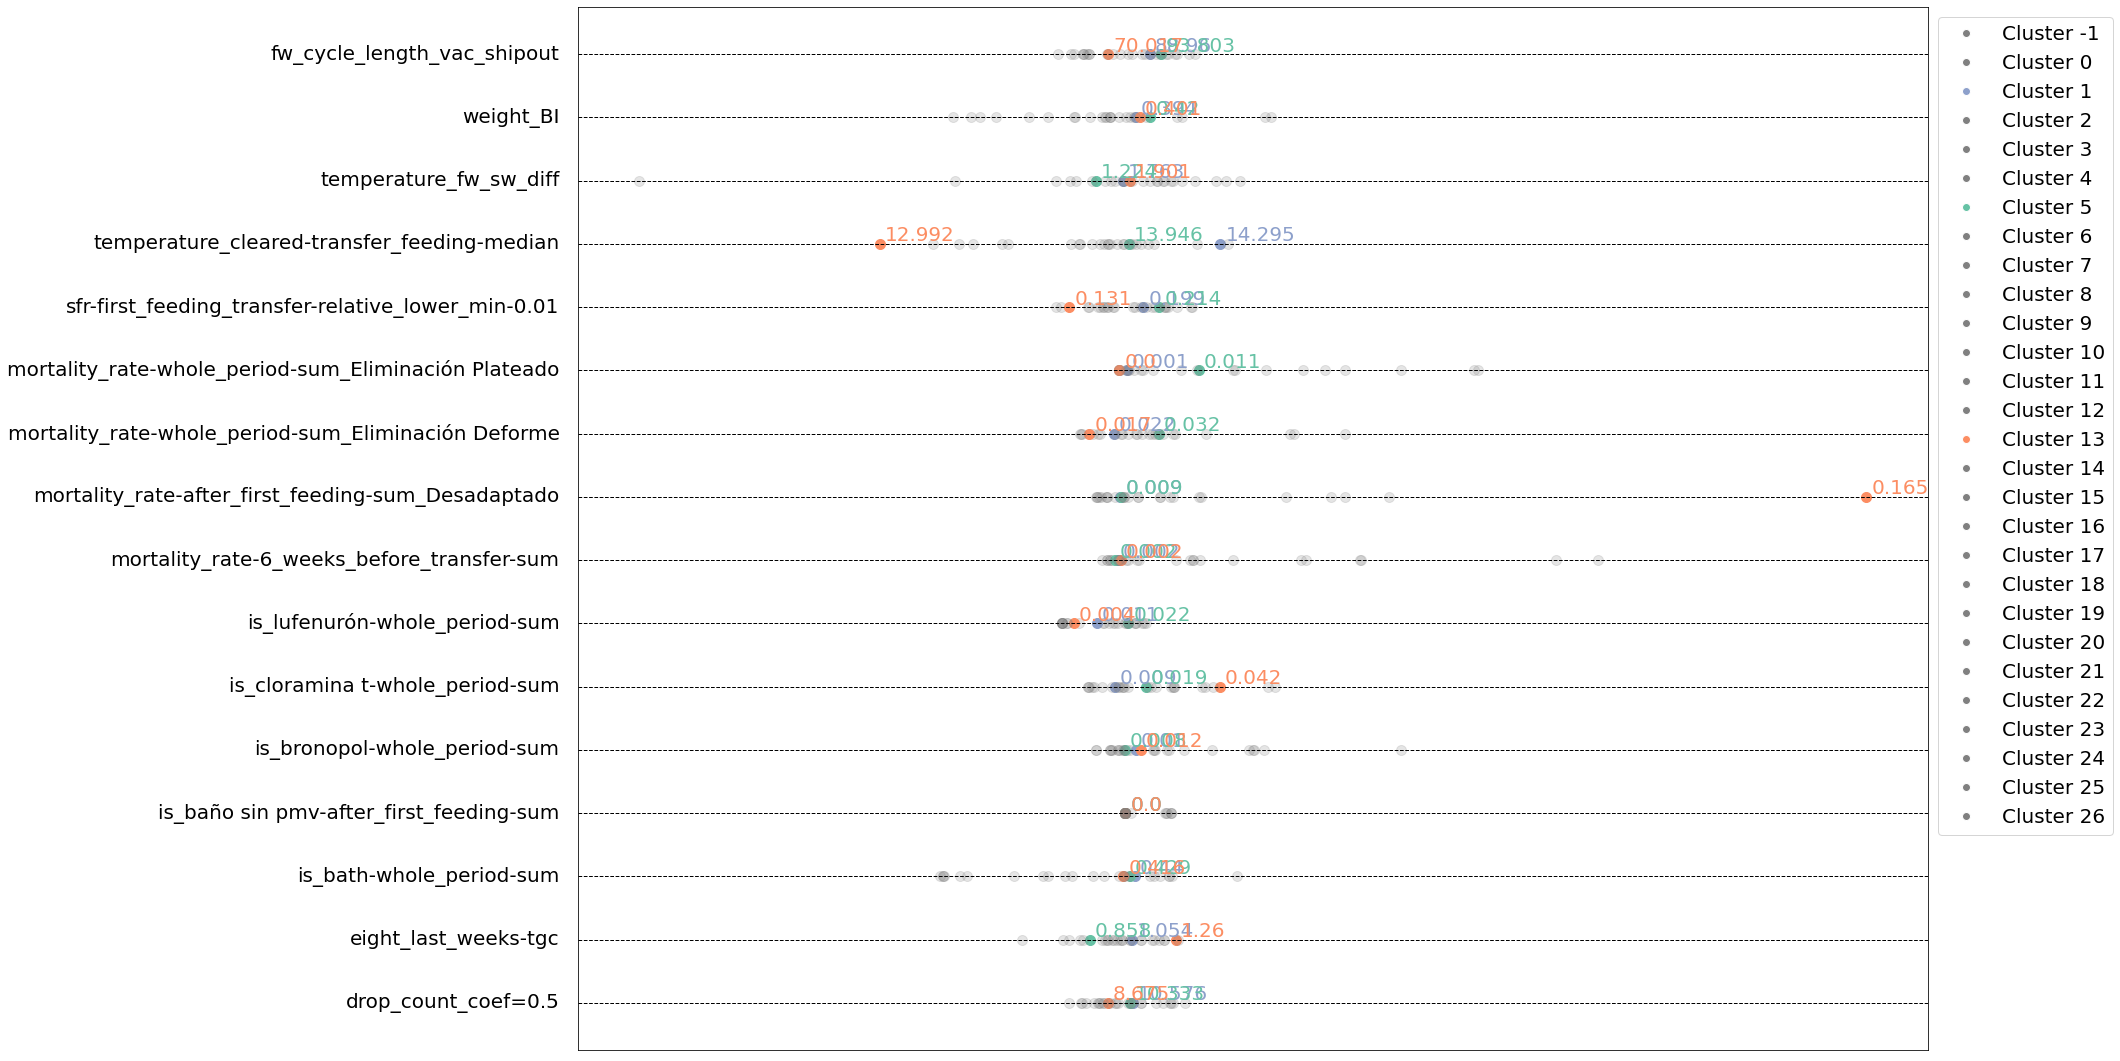

In [17]:
# fontsize = 20

# fig, ax = plt.subplots(figsize=(30, len(features) * 1.2))

# unique_clusters = params_unscaled['cluster'].unique()
# cluster_colors = []
# for cluster in unique_clusters:
#     if cluster not in best_clusters:
#         cluster_colors.append('grey')
#     else:
#         cluster_colors.append(sns.color_palette('Set2')[best_clusters.tolist().index(cluster)])

# # Plot horizontal lines for each factor and add dots for scaled values
# for idx, feature in enumerate(features):
#     ax.axhline(y=idx, color='black', linestyle='--', linewidth=1)
#     ax.text(1.05 * factors_targets_scaled[features].min().min(),
#             idx,
#             feature,
#             verticalalignment='center',
#             horizontalalignment='right',
#             fontsize=fontsize)

#     # Add dots for scaled values for each cluster with unique colors
#     for cluster, color in zip(unique_clusters, cluster_colors):

#         cluster_values_scaled = params_scaled.loc[
#             params_scaled['cluster'] == cluster, f'{feature}_mean'
#         ]

#         cluster_q1_scaled = params_scaled.loc[
#             params_scaled['cluster'] == cluster, f'{feature}_quantile_0.25'
#         ]
#         cluster_q3_scaled = params_scaled.loc[
#             params_scaled['cluster'] == cluster, f'{feature}_quantile_0.75'
#         ]
#         # Use original values for annotation
#         cluster_values = params_unscaled.loc[params_unscaled['cluster'] == cluster, f'{feature}_mean']  

#         # Only add annotations for clusters in best_clusters
#         if cluster in best_clusters:
#             ax.scatter(cluster_values_scaled, [idx] * len(cluster_values_scaled), color=color, marker='o', s=100)
#             # Label each dot with the original value
#             for scaled_value, value, q1, q3 in zip(
#                 cluster_values_scaled, cluster_values, cluster_q1_scaled, cluster_q3_scaled
#             ):
#                 pass
#                 ax.annotate(
#                     f'{round(value, 3)}',
#                     (scaled_value, idx),
#                     textcoords="offset points",
#                     xytext=(5, 3),
#                     ha='left',
#                     fontsize=fontsize, color=color
#                 )
#         else:
#             ax.scatter(
#                 cluster_values_scaled,
#                 [idx] * len(cluster_values_scaled),
#                 color='grey',
#                 marker='o',
#                 s=100,
#                 alpha=.2
#             )

# ax.yaxis.set_visible(False)
# ax.set_xticks([])

# legend_labels = [f'Cluster {cluster}' for cluster in unique_clusters]
# legend_handles = []
# for label, color in zip(legend_labels, cluster_colors):
#     legend_handles.append(
#         plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
#     )
# ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# plt.subplots_adjust(right=0.75)  # Adjust the value as needed
# save_path = img_path / 'clustering'
# save_path.mkdir(exist_ok=True)
# plt.savefig(f'{save_path}/best_cluster_parameter_description.jpg', dpi=300)

In [19]:
# if False:

#     # Create a figure with a single subplot
#     fig, ax = plt.subplots(figsize=(25, len(factors) * 0.5))

#     # Plot horizontal lines for each factor
#     for idx, factor in enumerate(features):
#         ax.axhline(y=idx, color='black', linestyle='--', linewidth=1)
#         ax.text(1.05 * factors_targets_scaled[features].min().min(),
#                 idx,
#                 feature,
#                 verticalalignment='center',
#                 horizontalalignment='right',
#                 fontsize=fontsize)

#         # Get unique clusters and their corresponding colors
#         unique_clusters = params_unscaled['cluster'].unique()
#         cluster_colors = sns.color_palette('Set2', n_colors=len(unique_clusters))

#         # Add dots for scaled values for each cluster with unique colors
#         for cluster, color in zip(unique_clusters, cluster_colors):
#             cluster_values_scaled = params_scaled.loc[params_scaled['cluster'] == cluster, f'{feature}_mean']
#             cluster_q1_scaled = params_scaled.loc[params_scaled['cluster'] == cluster, f'{feature}_quantile_0.25']
#             cluster_q3_scaled = params_scaled.loc[params_scaled['cluster'] == cluster, f'{feature}_quantile_0.75']
#              # Use original values for annotation
#             cluster_values = params_unscaled.loc[params_unscaled['cluster'] == cluster, f'{feature}_mean'] 
#             ax.scatter(cluster_values_scaled, [idx] * len(cluster_values_scaled), color=color, marker='o', s=50)

#             for scaled_value, value, q1, q3 in zip(
#                 cluster_values_scaled, cluster_values, cluster_q1_scaled, cluster_q3_scaled
#             ):
#                 ax.annotate(
#                     f'{round(value,2)}',
#                     (scaled_value, idx),
#                     textcoords="offset points",
#                     xytext=(5,3),
#                     ha='left',
#                     fontsize=10,
#                     color=color
#                 )

#     # Remove y-axis and set x-axis label
#     ax.yaxis.set_visible(False)
#     # ax.set_xlabel('Value')
#     ax.set_xticks([])

#     # Create legend
#     legend_labels = [f'Cluster {cluster}' for cluster in unique_clusters]
#     legend_handles = []
#     for label, color in zip(legend_labels, cluster_colors):
#         legend_handles.append(
#             plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
#         )

#     ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(.925, 1.2))
#     plt.subplots_adjust(right=0.75)  # Adjust the value as needed

#     plt.subplots_adjust(right=.75) 
#     save_path = img_path / 'clustering'
#     save_path.mkdir(exist_ok=True)
#     plt.savefig(f'{save_path}/cluster_full_parameter_description.jpg', dpi=300)

## 4. Validation

In [301]:
# Regardless of DROPNA values
test_factors[features] = test_factors[features].fillna(test_factors[features].median()).fillna(0)
test_factors

,locus_id,fish_group_id,transfer_year,is_ipn-whole_period-sum,is_nacl-after_first_feeding-sum,is_nacl-whole_period-sum,is_saprosafe aw-whole_period-sum,is_cloramina t-whole_period-sum,is_bronopol-whole_period-sum,sfr-2_weeks_before_transfer-relative_lower_min-0.01,...,number_of_weeks_with_summer_vac_transfer,is_cleaned_mean,is_desinfected_mean,weight_H,weight_M,vac_weight,vac_uta,vac_fish_count_mean,vac_conf_transfer_days,vac_conf_days
3,3046036,6165,2023,0.0,0.627778,0.469360,0.000000,0.095602,0.004484,1.000000,...,4.550578,0.019177,0.0,NaN,0.274635,67.478571,829.898897,51734.473341,59.189310,11.946874
78,3046444,6179,2023,0.0,0.633414,0.517115,0.001499,0.080664,0.004157,1.000000,...,3.714286,0.010612,0.0,NaN,0.274635,75.878194,1595.000000,22419.705882,108.000000,9.575004
91,3046497,6165,2023,0.0,0.617951,0.497754,0.000000,0.086881,0.004566,1.000000,...,4.428571,NaN,0.0,NaN,0.274635,62.817920,1092.000000,19714.000000,79.000000,1.233256
121,3046645,6179,2023,0.0,0.630675,0.506590,0.001698,0.085479,0.004259,1.000000,...,3.575822,0.017786,0.0,NaN,0.274635,68.684278,1760.528171,33781.205734,122.576714,1.617247
141,3046709,6165,2023,0.0,0.625734,0.476213,0.000000,0.102748,0.004545,1.000000,...,4.000000,0.028571,0.0,NaN,0.274635,74.433500,1006.000000,24460.000000,70.000000,0.912612
163,3046895,6179,2023,0.0,0.627050,0.543020,0.000000,0.079597,0.004210,1.000000,...,4.285714,NaN,0.0,NaN,0.274635,73.256018,1705.870208,27620.472234,117.505696,0.814253
176,3046983,6165,2023,0.0,0.628058,0.468678,0.000000,0.093844,0.004484,1.000000,...,4.571429,0.017143,0.0,NaN,0.274635,67.714701,801.000000,55000.000000,57.000000,13.909091
181,3047002,6179,2023,0.0,0.634935,0.526248,0.000000,0.081349,0.004246,1.000000,...,3.714286,0.023622,0.0,NaN,0.274635,66.106289,1687.000000,23794.250000,120.000000,0.969530
183,3047012,6179,2023,0.0,0.637394,0.536909,0.001667,0.075930,0.004220,1.000000,...,4.142857,0.027817,0.0,NaN,0.274635,73.588135,1717.459715,28671.279693,118.000000,1.548628
192,3047049,6165,2023,0.0,0.625761,0.473227,0.000000,0.102358,0.004515,1.000000,...,4.152447,0.028801,0.0,NaN,0.274635,73.873891,1005.530115,25008.176858,70.134253,0.882567


In [303]:
test_factors_targets = test_factors[features+key_columns].merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets[key_columns + ['nSFR']]
)

test_factors_targets.drop(key_columns, inplace=True, axis=1)

test_factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
test_factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)

test_factors_targets['mortality_perc'] = test_factors_targets['mortality'] * 100

In [304]:
scaler = RobustScaler()

test_factors_targets_scaled = test_factors_targets.copy()
test_factors_targets_scaled[features] = scaler.fit_transform(test_factors_targets[features])

In [305]:
params_scaled

,cluster,vac_conf_days_mean,mortality_rate-whole_period-sum_Embrionaria_mean,sfr-2_weeks_before_transfer-relative_lower_min-0.01_mean,is_nacl-after_first_feeding-sum_mean,is_luf_weighted_mean,weight_M_mean,fw_cycle_length_first_mvmt_shipout_mean,temperature_cleared-before_first_feeding-degree_days_mean,temperature_cleared-before_first_feeding-mean_mean,...,mortality_rate-after_first_feeding-sum_Desadaptado_median,is_nacl-whole_period-sum_median,mortality_rate-6_weeks_before_transfer-sum_median,days_btw_to_from_median,is_bronopol-whole_period-sum_median,drop_count_coef=0.5_median,temperature_cleared-transfer_feeding-degree_days_median,is_cloramina t-whole_period-sum_median,temperature_cleared-transfer_feeding-median_median,sfr-4_weeks_before_transfer-relative_lower_min-0.01_median
0,-1,0.575119,0.707382,-2.183314,-0.319379,-0.209546,0.478186,0.021815,0.328295,-0.172385,...,-0.172273,0.362254,0.630562,0.0,-0.021608,0.266401,0.098100,-0.026508,-0.215619,-3.612855e-01
1,0,0.688937,-0.044312,-1.196626,0.614898,0.206194,0.547805,-0.656162,-0.001341,0.201510,...,0.546023,0.211368,-0.518455,1.0,4.858719,-0.687993,-0.660226,-0.056257,0.256020,-6.021425e-01
2,1,0.808064,-0.030198,-0.421424,0.365778,-0.303211,0.413912,0.176860,0.031589,-0.246703,...,-0.405918,-0.391260,-0.360097,0.0,-0.042047,0.075522,0.062444,-0.253014,1.228413,3.609967e-16
3,2,-0.558988,-0.690240,0.000000,0.199637,-0.015753,0.000000,-0.460960,-0.050408,0.005666,...,-0.310820,1.065978,0.332642,0.0,1.814340,-0.497114,0.029133,-0.170122,0.587660,4.817140e-01
4,3,-0.141123,1.482640,-0.189254,-0.550063,-0.195361,0.381833,-0.728788,0.141824,0.633653,...,-0.404408,0.658141,-0.263523,0.0,0.550461,-0.574666,-0.540258,0.304977,-1.397065,1.174981e-01
5,4,0.360638,-0.298604,-1.672931,-1.196897,-0.332443,0.539015,-0.188888,-0.465816,0.475124,...,3.399586,1.055488,0.452094,0.0,0.769418,-0.115357,-0.038157,0.871046,-0.467637,-8.398478e-01
6,5,-0.513126,-0.585804,-0.496116,0.775599,-0.797290,0.541444,0.459020,-0.062384,0.002206,...,-0.171551,1.062362,0.200817,0.0,1.363192,0.699455,1.153594,-0.162664,0.194118,2.596135e-01
7,6,-0.347305,-0.007911,-0.682123,-1.022564,0.170056,0.281526,-0.334545,-0.061714,0.169109,...,-0.367212,0.044516,-0.574848,0.0,1.198414,-0.115357,-0.320170,0.097678,-0.093518,-1.825847e-01
8,7,-0.471195,0.038081,-0.097114,-1.562396,0.271046,0.279555,-0.499716,1.043751,0.023477,...,-0.301275,-0.309754,-0.009571,1.0,-0.005442,0.861396,-0.056495,2.002630,0.522973,2.901200e-01
9,8,0.138306,-0.055500,0.000000,-0.010770,0.013601,0.176608,0.063885,4.608662,-0.960468,...,0.595335,-0.022782,-0.377206,0.0,2.496467,-0.115357,-0.234235,-0.121275,-0.470355,6.021425e-01


In [307]:
vectors = test_factors_targets[features].values
centers = params_scaled[[f'{col}_mean' for col in features]].values

vector_distances = []
for center in centers:
    vector_distances.append(np.linalg.norm(vectors - center, axis=1))
vector_distances = pd.DataFrame(vector_distances).T

In [309]:
test_factors_targets['cluster'] = vector_distances.idxmin(axis=1)
test_factors_targets['cluster'] = test_factors_targets['cluster'].astype(int)

In [311]:
test_factors_targets

,vac_conf_days,mortality_rate-whole_period-sum_Embrionaria,sfr-2_weeks_before_transfer-relative_lower_min-0.01,is_nacl-after_first_feeding-sum,is_luf_weighted,weight_M,fw_cycle_length_first_mvmt_shipout,temperature_cleared-before_first_feeding-degree_days,temperature_cleared-before_first_feeding-mean,is_desinfected_mean,...,drop_count_coef=0.5,temperature_cleared-transfer_feeding-degree_days,is_cloramina t-whole_period-sum,temperature_cleared-transfer_feeding-median,sfr-4_weeks_before_transfer-relative_lower_min-0.01,mortality,tgc,nSFR,mortality_perc,cluster
0,11.946874,0.055636,1.000000,0.627778,0.030921,0.274635,446.00,727.358581,4.603535,0.0,...,11.145954,3691.453515,0.095602,13.272354,0.894295,0.005902,2.530637,0.819303,0.590161,3
1,9.575004,0.057945,1.000000,0.633414,0.033670,0.274635,481.00,727.401694,4.603570,0.0,...,5.000000,3712.007739,0.080664,13.656644,1.000000,0.005290,NaN,0.845117,0.529026,3
2,1.233256,0.051454,1.000000,0.617951,0.023529,0.274635,438.00,727.360672,4.603549,0.0,...,10.000000,3711.653808,0.086881,13.600000,0.777778,0.003962,2.461813,0.824990,0.396165,3
3,1.617247,0.058212,1.000000,0.630675,0.037733,0.274635,469.55,727.401694,4.603570,0.0,...,12.810033,3712.007739,0.085479,13.656644,0.926991,0.015721,NaN,0.940193,1.572080,3
4,0.912612,0.055109,1.000000,0.625734,0.031746,0.274635,440.00,727.375717,4.603644,0.0,...,9.000000,3788.768855,0.102748,13.800000,0.777778,0.004585,2.632309,0.807570,0.458491,3
5,0.814253,0.054154,1.000000,0.627050,0.036486,0.274635,475.00,727.401694,4.603570,0.0,...,13.505696,3712.007739,0.079597,13.656644,0.945077,0.004148,NaN,0.958899,0.414810,3
6,13.909091,0.055827,1.000000,0.628058,0.031496,0.274635,446.00,727.351213,4.603489,0.0,...,11.000000,3665.767942,0.093844,13.200000,0.888889,0.006965,2.709486,0.836847,0.696536,3
7,0.969530,0.060491,1.000000,0.634935,0.035088,0.274635,471.00,727.401694,4.603570,0.0,...,11.000000,3712.007739,0.081349,13.656644,0.851852,0.007628,NaN,0.996368,0.762785,3
8,1.548628,0.059494,1.000000,0.637394,0.036856,0.274635,474.00,727.401694,4.603570,0.0,...,12.814984,3712.007739,0.075930,13.656644,0.941481,0.004698,NaN,0.947347,0.469789,3
9,0.882567,0.055069,1.000000,0.625761,0.031465,0.274635,443.00,727.377460,4.603655,0.0,...,9.201379,3828.874245,0.102358,13.790378,0.849366,0.005578,2.566401,0.808946,0.557797,3


In [310]:
test_clusters = test_factors_targets['cluster'].unique()

print('Intersection between top 5 nsfr and test clusters: ', end='')
print(top_5_clusters_by_nsfr.intersection(test_clusters).tolist())
print('Intersection between top 5 mortality and test clusters: ', end='')
print(top_5_clusters_by_mortality.intersection(test_clusters).tolist())

print('Mean metrics by test clusters')
display(test_factors_targets.groupby('cluster')[['mortality_perc', 'nSFR']].mean())

print('Mean metrics by train clusters')
display(factors_targets[factors_targets['cluster'].isin(test_clusters)]\
        .groupby('cluster')[['mortality_perc', 'nSFR']].mean())

print('General mean metrics')
display(
    pd.DataFrame(factors_targets[['mortality_perc', 'nSFR']].mean().T)\
    .rename(columns={0: 'averaged_population_value'})
)

Intersection between top 5 nsfr and test clusters: []
Intersection between top 5 mortality and test clusters: []
Mean metrics by test clusters


,mortality_perc,nSFR
cluster,,
3,0.7129,0.863171


Mean metrics by train clusters


,mortality_perc,nSFR
cluster,,
3,2.118894,0.971392


General mean metrics


,averaged_population_value
mortality_perc,1.493270
nSFR,0.952059
